In [ ]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Load dataset
df = pd.read_csv('text.csv')

# Preprocessing sederhana
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

import re
df['cleaned_message'] = df['Message'].apply(clean_text)

# Split data
X = df['cleaned_message']
y = df['Category']
X_train, X_test, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = tfidf_vectorizer.transform(X_test)

# Training dan prediksi
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, train_y)
y_pred = naive_bayes_classifier.predict(X_test_tf)

print(metrics.classification_report(test_y, y_pred))


# Text Classification dengan Naive Bayes

Notebook ini melakukan klasifikasi teks SMS spam/ham menggunakan algoritma Naive Bayes Multinomial dari scikit-learn.

## Dataset
- **File**: text.csv
- **Kolom**: Category (ham/spam), Message (teks SMS)
- **Tujuan**: Mengklasifikasikan SMS sebagai spam atau ham (bukan spam)


In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re
import string
import warnings
warnings.filterwarnings('ignore')

# Set style untuk plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Load dan Eksplorasi Data


=== INFORMASI DATASET ===
Shape dataset: (5572, 2)
Kolom: ['Category', 'Message']

=== PREVIEW DATA ===
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

=== INFORMASI STATISTIK ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None

=== DISTRIBUSI KATEGORI ===
Category
ham     4825
spam     747
Name: count, dtype: int64



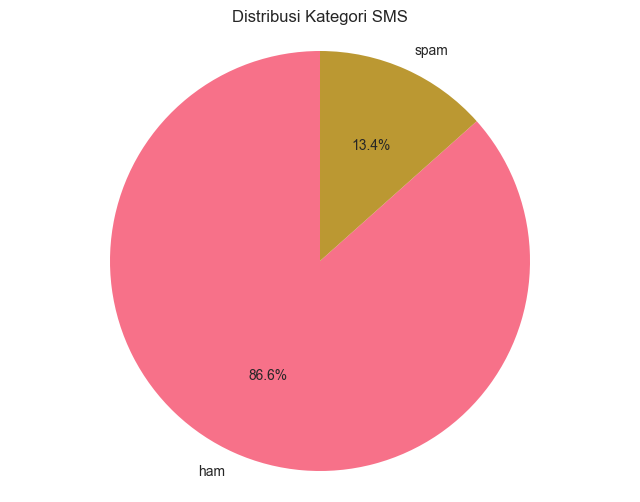

In [2]:
# Load dataset
df = pd.read_csv('text.csv')

# Tampilkan informasi dataset
print("=== INFORMASI DATASET ===")
print(f"Shape dataset: {df.shape}")
print(f"Kolom: {list(df.columns)}")
print()

print("=== PREVIEW DATA ===")
print(df.head())
print()

print("=== INFORMASI STATISTIK ===")
print(df.info())
print()

print("=== DISTRIBUSI KATEGORI ===")
print(df['Category'].value_counts())
print()

# Visualisasi distribusi kategori
plt.figure(figsize=(8, 6))
category_counts = df['Category'].value_counts()
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Kategori SMS')
plt.axis('equal')
plt.show()


=== CONTOH PREPROCESSING ===
Sebelum cleaning: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Sesudah cleaning: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat

Sedang membersihkan data...
=== STATISTIK PANJANG TEKS ===
count    5572.000000
mean       72.921213
std        54.251005
min         0.000000
25%        33.000000
50%        57.000000
75%       109.000000
max       888.000000
Name: text_length, dtype: float64



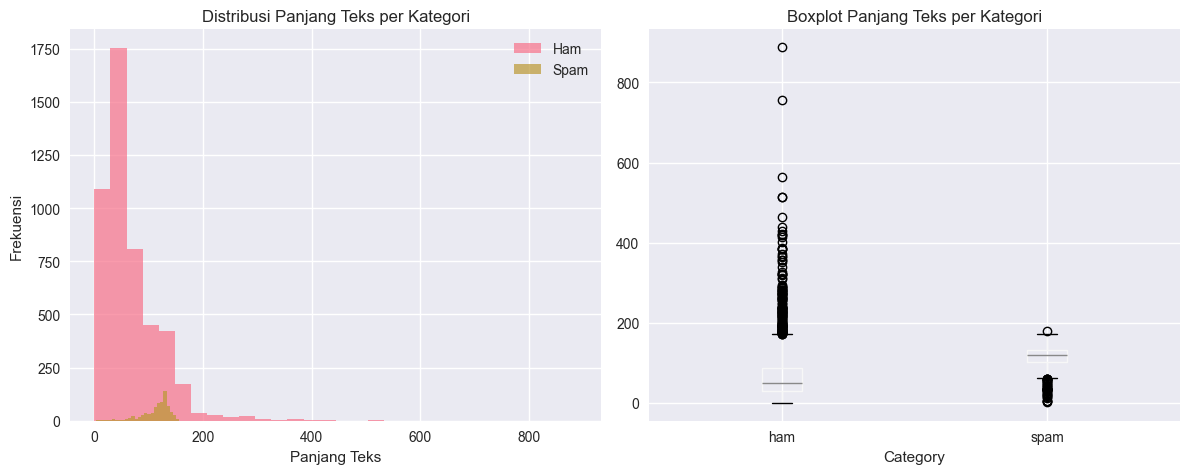

In [3]:
# Fungsi untuk membersihkan teks
def clean_text(text):
    """
    Membersihkan teks SMS dengan menghapus karakter yang tidak diperlukan
    """
    # Konversi ke lowercase
    text = text.lower()
    
    # Hapus karakter khusus dan angka
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Hapus whitespace berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Contoh sebelum dan sesudah cleaning
print("=== CONTOH PREPROCESSING ===")
sample_text = df['Message'].iloc[0]
print(f"Sebelum cleaning: {sample_text}")
print(f"Sesudah cleaning: {clean_text(sample_text)}")
print()

# Terapkan cleaning ke semua data
print("Sedang membersihkan data...")
df['cleaned_message'] = df['Message'].apply(clean_text)

print("=== STATISTIK PANJANG TEKS ===")
df['text_length'] = df['cleaned_message'].apply(len)
print(df['text_length'].describe())
print()

# Visualisasi panjang teks per kategori
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df[df['Category'] == 'ham']['text_length'].hist(alpha=0.7, label='Ham', bins=30)
df[df['Category'] == 'spam']['text_length'].hist(alpha=0.7, label='Spam', bins=30)
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.title('Distribusi Panjang Teks per Kategori')
plt.legend()

plt.subplot(1, 2, 2)
df.boxplot(column='text_length', by='Category', ax=plt.gca())
plt.title('Boxplot Panjang Teks per Kategori')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()


## 3. Pembagian Data Train dan Test


In [4]:
# Persiapan data untuk training
X = df['cleaned_message']  # Features (teks yang sudah dibersihkan)
y = df['Category']         # Target (ham/spam)

print("=== PEMBAGIAN DATA ===")
print(f"Total data: {len(X)}")
print(f"Kategori target: {y.unique()}")
print()

# Split data menjadi train dan test set (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Mempertahankan proporsi kelas
)

print(f"Data training: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Data testing: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print()

print("=== DISTRIBUSI KATEGORI DI TRAIN SET ===")
print(y_train.value_counts())
print()

print("=== DISTRIBUSI KATEGORI DI TEST SET ===")
print(y_test.value_counts())
print()

# Konversi target ke numerik untuk kompatibilitas dengan sklearn
# 0 = ham, 1 = spam
label_mapping = {'ham': 0, 'spam': 1}
y_train_numeric = y_train.map(label_mapping)
y_test_numeric = y_test.map(label_mapping)

print("=== MAPPING LABEL ===")
print("ham -> 0")
print("spam -> 1")
print()
print(f"Train set - ham: {sum(y_train_numeric == 0)}, spam: {sum(y_train_numeric == 1)}")
print(f"Test set - ham: {sum(y_test_numeric == 0)}, spam: {sum(y_test_numeric == 1)}")


=== PEMBAGIAN DATA ===
Total data: 5572
Kategori target: ['ham' 'spam']

Data training: 4457 (80.0%)
Data testing: 1115 (20.0%)

=== DISTRIBUSI KATEGORI DI TRAIN SET ===
Category
ham     3859
spam     598
Name: count, dtype: int64

=== DISTRIBUSI KATEGORI DI TEST SET ===
Category
ham     966
spam    149
Name: count, dtype: int64

=== MAPPING LABEL ===
ham -> 0
spam -> 1

Train set - ham: 3859, spam: 598
Test set - ham: 966, spam: 149


## 4. Vectorization (TF-IDF)


In [5]:
# Menggunakan TF-IDF Vectorizer untuk mengubah teks menjadi vektor numerik
print("=== TF-IDF VECTORIZATION ===")

# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,        # Maksimal 5000 fitur (kata yang paling penting)
    stop_words='english',     # Hapus stop words bahasa Inggris
    ngram_range=(1, 2),       # Gunakan unigram dan bigram
    min_df=2,                 # Kata harus muncul minimal 2 kali
    max_df=0.95               # Kata tidak boleh muncul di lebih dari 95% dokumen
)

print("Sedang melakukan vectorization...")

# Fit dan transform data training
X_train_tf = tfidf_vectorizer.fit_transform(X_train)

# Transform data testing (hanya transform, tidak fit)
X_test_tf = tfidf_vectorizer.transform(X_test)

print(f"Shape X_train_tf: {X_train_tf.shape}")
print(f"Shape X_test_tf: {X_test_tf.shape}")
print(f"Jumlah fitur (vocabulary): {len(tfidf_vectorizer.get_feature_names_out())}")
print()

# Tampilkan beberapa fitur terpenting
print("=== CONTOH FITUR (KATA) TERPENTING ===")
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"10 fitur pertama: {feature_names[:10]}")
print(f"10 fitur terakhir: {feature_names[-10:]}")
print()

# Cek sparsity matrix
print(f"Sparsity train set: {(1 - X_train_tf.nnz / (X_train_tf.shape[0] * X_train_tf.shape[1])) * 100:.2f}%")
print(f"Sparsity test set: {(1 - X_test_tf.nnz / (X_test_tf.shape[0] * X_test_tf.shape[1])) * 100:.2f}%")


=== TF-IDF VECTORIZATION ===
Sedang melakukan vectorization...
Shape X_train_tf: (4457, 5000)
Shape X_test_tf: (1115, 5000)
Jumlah fitur (vocabulary): 5000

=== CONTOH FITUR (KATA) TERPENTING ===
10 fitur pertama: ['aah' 'aathiwhere' 'aathiwhere dear' 'ability' 'abiola' 'abj' 'able'
 'able come' 'able deliver' 'abt']
10 fitur terakhir: ['yuo exmpel' 'yuo raed' 'yup' 'yup im' 'yup lor' 'yup ok' 'yup thk' 'zed'
 'zed logopic' 'zed profit']

Sparsity train set: 99.84%
Sparsity test set: 99.86%


## 5. Training Model Naive Bayes


In [6]:
# Inisialisasi dan training model Naive Bayes Multinomial
print("=== TRAINING NAIVE BAYES CLASSIFIER ===")

# Buat instance classifier
naive_bayes_classifier = MultinomialNB()

# Training model
print("Sedang melakukan training...")
naive_bayes_classifier.fit(X_train_tf, y_train_numeric)

print("Training selesai!")
print()

# Informasi tentang model yang sudah dilatih
print("=== INFORMASI MODEL ===")
print(f"Kelas yang dipelajari: {naive_bayes_classifier.classes_}")
print(f"Jumlah fitur yang digunakan: {naive_bayes_classifier.feature_count_.shape[1]}")
print(f"Jumlah sampel per kelas: {naive_bayes_classifier.class_count_}")
print()

# Hitung prior probabilities
prior_probs = naive_bayes_classifier.class_count_ / naive_bayes_classifier.class_count_.sum()
print("Prior probabilities:")
for i, class_name in enumerate(['ham', 'spam']):
    print(f"  {class_name}: {prior_probs[i]:.4f}")
print()

# Prediksi pada data training untuk melihat performa training
print("=== EVALUASI PADA TRAINING SET ===")
y_train_pred = naive_bayes_classifier.predict(X_train_tf)
train_accuracy = accuracy_score(y_train_numeric, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")


=== TRAINING NAIVE BAYES CLASSIFIER ===
Sedang melakukan training...
Training selesai!

=== INFORMASI MODEL ===
Kelas yang dipelajari: [0 1]
Jumlah fitur yang digunakan: 5000
Jumlah sampel per kelas: [3859.  598.]

Prior probabilities:
  ham: 0.8658
  spam: 0.1342

=== EVALUASI PADA TRAINING SET ===
Training Accuracy: 0.9807 (98.07%)
